In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys

In [3]:
base_path = pathlib.Path(os.getcwd())
base_path = str(base_path.parent)
sys.path = [base_path] + sys.path

In [4]:
import glob
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [6]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.0, color_codes=True)

In [7]:
os.makedirs("./img/", exist_ok=True)
os.makedirs("./score/", exist_ok=True)

In [8]:
def set_experimental_environment(seed=6902):
    K.clear_session()

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    python_random.seed(seed)

    # The below set_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see:
    # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
    tf.random.set_seed(seed)

In [9]:
from pynvml import *

try:
    nvmlInit()
    print("Driver Version:", nvmlSystemGetDriverVersion())
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
    nvmlShutdown()
except NVMLError as error:
    print(error)

Driver Version: b'419.17'
Device 0 : b'GeForce GTX 1070 Ti'


In [10]:
from cpuinfo import get_cpu_info

for key, value in get_cpu_info().items():
    print("{0}: {1}".format(key, value))

python_version: 3.6.10.final.0 (64 bit)
cpuinfo_version: [7, 0, 0]
cpuinfo_version_string: 7.0.0
arch: X86_64
bits: 64
count: 12
arch_string_raw: AMD64
vendor_id_raw: GenuineIntel
brand_raw: Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
hz_advertised_friendly: 3.2000 GHz
hz_actual_friendly: 3.1920 GHz
hz_advertised: [3200000000, 0]
hz_actual: [3192000000, 0]
l2_cache_size: 1572864
stepping: 10
model: 158
family: 6
l3_cache_size: 12582912
flags: ['3dnow', '3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'apic', 'avx', 'avx2', 'bmi1', 'bmi2', 'clflush', 'clflushopt', 'cmov', 'cx16', 'cx8', 'de', 'dtes64', 'dts', 'erms', 'est', 'f16c', 'fma', 'fpu', 'fxsr', 'hle', 'ht', 'hypervisor', 'ia64', 'invpcid', 'lahf_lm', 'mca', 'mce', 'mmx', 'movbe', 'mpx', 'msr', 'mtrr', 'osxsave', 'pae', 'pat', 'pbe', 'pcid', 'pclmulqdq', 'pdcm', 'pge', 'pni', 'popcnt', 'pse', 'pse36', 'rdrnd', 'rdseed', 'rtm', 'sep', 'serial', 'smap', 'smep', 'ss', 'sse', 'sse2', 'sse4_1', 'sse4_2', 'ssse3', 'tm', 'tm2', 'tsc', 'vme', 

In [11]:
import psutil 

mem = psutil.virtual_memory() 
print("memory: {0:.2f}GB".format(mem.total / 1024**3))

memory: 15.92GB


In [12]:
BAYES_MODELS = [
    "MNIST-CNN",
]

LAST_ACTIVATIONS = [
    "softmax",
    "sigmoid",
]

PREDICTION_MODES = [
    "Normal-mode",
    "Linear-mode",
    "Independent-mode",
    "Upper-mode",
    "MC-mode",
]

DATASETS = [
    "MNIST",
    "Fashion",
    "Kuzushiji",
    "Kannada",
    "EMNIST-MNIST",
]

In [13]:
class Args(object):
    max_seed = 30
    train_domain = DATASETS[1]
    bayes_model= BAYES_MODELS[0]
    num_mc = 2000
    optimizer = "Adam"
    train_batch_size = 128
    test_batch_size = 2048
    max_epochs = 100
    patience = 10
    rho = 0.01

In [14]:
def kuzushiji_load_data():
    ds = tfds.load(
        "kmnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    return (x_train, y_train), (x_test, y_test)


def kannada_load_data():
    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_train.npz",
    )
    y_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_train.npz",
    )
    x_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_test.npz",
    )
    y_test = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_test.npz",
    )
    x_test = np.load(path)["arr_0"]

    return (x_train, y_train), (x_test, y_test)


def emnist_mnist_load_data():
    ds = tfds.load(
        "emnist/mnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    x_train = np.array([x.T for x in x_train])
    x_test = np.array([x.T for x in x_test])

    return (x_train, y_train), (x_test, y_test)


def load_dataset(dataset, val_size=1.0 / 6.0):
    if dataset == DATASETS[0]:
        load_data = keras.datasets.mnist.load_data
    elif dataset == DATASETS[1]:
        load_data = keras.datasets.fashion_mnist.load_data
    elif dataset == DATASETS[2]:
        load_data = kuzushiji_load_data
    elif dataset == DATASETS[3]:
        load_data = kannada_load_data
    elif dataset == DATASETS[4]:
        load_data = emnist_mnist_load_data
    else:
        raise ValueError("Error")

    # input image dimensions
    num_classes = 10

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    if val_size > 0.0:
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=val_size, stratify=y_train
        )
    else:
        x_val, y_val = x_train, y_train

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), num_classes

In [15]:
def calc_softmax_entropy(prob):
    entropy = np.sum(-prob * np.log(np.maximum(prob, 1.0e-5)), axis=-1)
    return entropy


def calc_sigmoid_entropy(prob):
    entropy = np.sum(
        -prob * np.log(np.maximum(prob, 1.0e-5))
        - (1.0 - prob) * np.log(np.maximum(1.0 - prob, 1.0e-5)),
        axis=-1,
    )
    return entropy

In [16]:
def create_last_bayes_model(input_shape, output_shape, last_activation):
    # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    inputs = keras.Input(input_shape)
    conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1 = layers.Dropout(0.25)(pool1)
    flat1 = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation="relu")(flat1)
    drop2 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(output_shape, activation=last_activation)(drop2)
    model = keras.Model(inputs=inputs, outputs=dense2)

    return model


def create_bayes_model(bayes_model_name, input_shape, output_shape, last_activation):
    if bayes_model_name == BAYES_MODELS[0]:
        model = create_last_bayes_model(input_shape, output_shape, last_activation)
    else:
        raise ValueError()

    return model

In [17]:
args = Args()

In [18]:
from vpbnn import vlayers
from vpbnn.models import nn2vpbnn

for seed in range(args.max_seed):
    for last_activation in LAST_ACTIVATIONS:
        set_experimental_environment(seed)
        
        (x_train, y_train), (x_val, y_val), (_, _), num_classes = load_dataset(
            args.train_domain
        )        
        
        input_shape = x_train.shape[1:]
        model = create_bayes_model(
            args.bayes_model, input_shape, num_classes, last_activation
        )

        if last_activation == LAST_ACTIVATIONS[0]:
            loss_func = "categorical_crossentropy"
            calc_entropy = calc_softmax_entropy
        elif last_activation == LAST_ACTIVATIONS[1]:
            loss_func = "binary_crossentropy"
            calc_entropy = calc_sigmoid_entropy
        else:
            raise ValueError()

        es = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=args.patience,
            verbose=1,
            mode="auto",
            restore_best_weights=True,
        )

        model.compile(
            loss=loss_func, optimizer=args.optimizer, metrics=["accuracy"],
        )

        model.fit(
            x_train,
            y_train,
            batch_size=args.train_batch_size,
            epochs=args.max_epochs,
            verbose=2,
            validation_data=(x_val, y_val),
            callbacks=[es],
        )
        
        vmodel = nn2vpbnn(model, rho=args.rho)
        
        score_dfs = []
        for prediction_type in PREDICTION_MODES:
            for test_domain in DATASETS:
                (_, _), (_, _), (x_test, y_test), _ = load_dataset(test_domain)
                if prediction_type == PREDICTION_MODES[0]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 0
                    vmodel.compile(loss=loss_func)

                    y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[1]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 1
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[2]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 2
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[3]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 3
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)            
                elif prediction_type == PREDICTION_MODES[4]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 4
                    vmodel.compile(loss=loss_func)

                    y_probs = []
                    for _ in range(args.num_mc):
                        for layer in model.layers:
                            if isinstance(layer, vlayers.VarianceDropout):
                                layer.update_dropout_mask()
                        y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                        y_probs.append(y_prob)
                    y_probs = np.array(y_probs)
                    y_prob = y_probs.mean(axis=0)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(y_probs.std(axis=0, ddof=1), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                else:
                    raise ValueError()
        score_df = pd.concat(score_dfs, ignore_index=True)
        score_df["seed"] = seed
        score_df["bayes_model"] = args.bayes_model
        score_df["last_activation"] = last_activation    
        score_df.to_csv("score/ood_{0}_{1:03}.csv".format(last_activation, seed), index=False)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 6s - loss: 0.5422 - accuracy: 0.8082 - val_loss: 0.3155 - val_accuracy: 0.8836
Epoch 2/100
50000/50000 - 3s - loss: 0.3495 - accuracy: 0.8753 - val_loss: 0.2710 - val_accuracy: 0.8990
Epoch 3/100
50000/50000 - 3s - loss: 0.3015 - accuracy: 0.8914 - val_loss: 0.2518 - val_accuracy: 0.9060
Epoch 4/100
50000/50000 - 3s - loss: 0.2713 - accuracy: 0.9025 - val_loss: 0.2297 - val_accuracy: 0.9153
Epoch 5/100
50000/50000 - 3s - loss: 0.2504 - accuracy: 0.9089 - val_loss: 0.2253 - val_accuracy: 0.9168
Epoch 6/100
50000/50000 - 3s - loss: 0.2250 - accuracy: 0.9177 - val_loss: 0.2263 - val_accuracy: 0.9150
Epoch 7/100
50000/50000 - 3s - loss: 0.2080 - accuracy: 0.9248 - val_loss: 0.2078 - val_accuracy: 0.9273
Epoch 8/100
50000/50000 - 3s - loss: 0.1933 - accuracy: 0.9288 - val_loss: 0.2056 - val_accuracy: 0.9253
Epoch 9/100
50000/50000 - 3s - loss: 0.1773 - accuracy: 0.9334 - val_loss: 0.2057 - val_accuracy: 0.9253
Epoch

Epoch 13/100
50000/50000 - 3s - loss: 0.0329 - accuracy: 0.9871 - val_loss: 0.0379 - val_accuracy: 0.9852
Epoch 14/100
50000/50000 - 3s - loss: 0.0319 - accuracy: 0.9873 - val_loss: 0.0384 - val_accuracy: 0.9854
Epoch 15/100
50000/50000 - 3s - loss: 0.0308 - accuracy: 0.9879 - val_loss: 0.0387 - val_accuracy: 0.9857
Epoch 16/100
50000/50000 - 3s - loss: 0.0295 - accuracy: 0.9883 - val_loss: 0.0393 - val_accuracy: 0.9857
Epoch 17/100
50000/50000 - 3s - loss: 0.0284 - accuracy: 0.9888 - val_loss: 0.0397 - val_accuracy: 0.9855
Epoch 18/100
50000/50000 - 3s - loss: 0.0274 - accuracy: 0.9891 - val_loss: 0.0404 - val_accuracy: 0.9853
Epoch 19/100
50000/50000 - 3s - loss: 0.0266 - accuracy: 0.9891 - val_loss: 0.0408 - val_accuracy: 0.9858
Epoch 20/100
50000/50000 - 3s - loss: 0.0256 - accuracy: 0.9895 - val_loss: 0.0383 - val_accuracy: 0.9858
Epoch 21/100
50000/50000 - 3s - loss: 0.0252 - accuracy: 0.9897 - val_loss: 0.0406 - val_accuracy: 0.9858
Epoch 22/100
50000/50000 - 3s - loss: 0.0241 -

Epoch 19/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.1076 - accuracy: 0.9585 - val_loss: 0.2376 - val_accuracy: 0.9284
Epoch 00019: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1187 - accuracy: 0.9547 - val_loss: 0.0646 - val_accuracy: 0.9751
Epoch 2/100
50000/50000 - 3s - loss: 0.0719 - accuracy: 0.9724 - val_loss: 0.0553 - val_accuracy: 0.9786
Epoch 3/100
50000/50000 - 3s - loss: 0.0616 - accuracy: 0.9761 - val_loss: 0.0485 - val_accuracy: 0.9814
Epoch 4/100
50000/50000 - 3s - loss: 0.0560 - accuracy: 0.9785 - val_loss: 0.0476 - val_accuracy: 0.9815
Epoch 5/100
50000/50000 - 3s - loss: 0.0516 - accuracy: 0.9800 - val_loss: 0.0436 - val_accuracy: 0.9834
Epoch 6/100
50000/50000 - 3s - loss: 0.0475 - accuracy: 0.9816 - val_loss: 0.0443 - val_accuracy: 0.9827
Epoch 7/100
50000/50000 - 3s - loss: 0.0447 - accuracy: 0.9826 - val_loss: 0.0410 - val_accuracy: 0.9844
Epoch 8/100
50000/50000 -

Epoch 24/100
50000/50000 - 3s - loss: 0.0234 - accuracy: 0.9905 - val_loss: 0.0400 - val_accuracy: 0.9871
Epoch 25/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0225 - accuracy: 0.9911 - val_loss: 0.0388 - val_accuracy: 0.9871
Epoch 00025: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5374 - accuracy: 0.8094 - val_loss: 0.3366 - val_accuracy: 0.8777
Epoch 2/100
50000/50000 - 3s - loss: 0.3451 - accuracy: 0.8757 - val_loss: 0.2956 - val_accuracy: 0.8954
Epoch 3/100
50000/50000 - 3s - loss: 0.2984 - accuracy: 0.8923 - val_loss: 0.2733 - val_accuracy: 0.9019
Epoch 4/100
50000/50000 - 3s - loss: 0.2645 - accuracy: 0.9032 - val_loss: 0.2581 - val_accuracy: 0.9058
Epoch 5/100
50000/50000 - 3s - loss: 0.2391 - accuracy: 0.9113 - val_loss: 0.2391 - val_accuracy: 0.9153
Epoch 6/100
50000/50000 - 3s - loss: 0.2234 - accuracy: 0.9172 - val_loss: 0.2297 - val_accuracy: 0.9137
Epoch 7/100
50000/50000 

Epoch 3/100
50000/50000 - 3s - loss: 0.0613 - accuracy: 0.9762 - val_loss: 0.0512 - val_accuracy: 0.9797
Epoch 4/100
50000/50000 - 3s - loss: 0.0551 - accuracy: 0.9787 - val_loss: 0.0477 - val_accuracy: 0.9812
Epoch 5/100
50000/50000 - 3s - loss: 0.0512 - accuracy: 0.9801 - val_loss: 0.0457 - val_accuracy: 0.9823
Epoch 6/100
50000/50000 - 3s - loss: 0.0476 - accuracy: 0.9816 - val_loss: 0.0441 - val_accuracy: 0.9827
Epoch 7/100
50000/50000 - 3s - loss: 0.0452 - accuracy: 0.9823 - val_loss: 0.0427 - val_accuracy: 0.9834
Epoch 8/100
50000/50000 - 3s - loss: 0.0427 - accuracy: 0.9835 - val_loss: 0.0429 - val_accuracy: 0.9831
Epoch 9/100
50000/50000 - 3s - loss: 0.0407 - accuracy: 0.9844 - val_loss: 0.0426 - val_accuracy: 0.9832
Epoch 10/100
50000/50000 - 3s - loss: 0.0388 - accuracy: 0.9849 - val_loss: 0.0412 - val_accuracy: 0.9844
Epoch 11/100
50000/50000 - 3s - loss: 0.0363 - accuracy: 0.9857 - val_loss: 0.0416 - val_accuracy: 0.9841
Epoch 12/100
50000/50000 - 3s - loss: 0.0354 - accura

Epoch 9/100
50000/50000 - 3s - loss: 0.1925 - accuracy: 0.9275 - val_loss: 0.2243 - val_accuracy: 0.9253
Epoch 10/100
50000/50000 - 3s - loss: 0.1834 - accuracy: 0.9307 - val_loss: 0.2016 - val_accuracy: 0.9319
Epoch 11/100
50000/50000 - 3s - loss: 0.1696 - accuracy: 0.9368 - val_loss: 0.2041 - val_accuracy: 0.9304
Epoch 12/100
50000/50000 - 3s - loss: 0.1568 - accuracy: 0.9410 - val_loss: 0.2074 - val_accuracy: 0.9301
Epoch 13/100
50000/50000 - 3s - loss: 0.1493 - accuracy: 0.9432 - val_loss: 0.2061 - val_accuracy: 0.9324
Epoch 14/100
50000/50000 - 3s - loss: 0.1422 - accuracy: 0.9465 - val_loss: 0.2188 - val_accuracy: 0.9277
Epoch 15/100
50000/50000 - 3s - loss: 0.1329 - accuracy: 0.9499 - val_loss: 0.2147 - val_accuracy: 0.9309
Epoch 16/100
50000/50000 - 3s - loss: 0.1266 - accuracy: 0.9522 - val_loss: 0.2097 - val_accuracy: 0.9294
Epoch 17/100
50000/50000 - 3s - loss: 0.1220 - accuracy: 0.9525 - val_loss: 0.2172 - val_accuracy: 0.9339
Epoch 18/100
50000/50000 - 3s - loss: 0.1136 - 

Epoch 16/100
50000/50000 - 3s - loss: 0.0298 - accuracy: 0.9882 - val_loss: 0.0393 - val_accuracy: 0.9854
Epoch 17/100
50000/50000 - 3s - loss: 0.0292 - accuracy: 0.9887 - val_loss: 0.0394 - val_accuracy: 0.9855
Epoch 18/100
50000/50000 - 3s - loss: 0.0281 - accuracy: 0.9888 - val_loss: 0.0396 - val_accuracy: 0.9859
Epoch 19/100
50000/50000 - 3s - loss: 0.0267 - accuracy: 0.9893 - val_loss: 0.0414 - val_accuracy: 0.9859
Epoch 20/100
50000/50000 - 3s - loss: 0.0259 - accuracy: 0.9897 - val_loss: 0.0420 - val_accuracy: 0.9854
Epoch 21/100
50000/50000 - 3s - loss: 0.0256 - accuracy: 0.9897 - val_loss: 0.0400 - val_accuracy: 0.9862
Epoch 22/100
50000/50000 - 3s - loss: 0.0247 - accuracy: 0.9899 - val_loss: 0.0427 - val_accuracy: 0.9859
Epoch 23/100
50000/50000 - 3s - loss: 0.0235 - accuracy: 0.9906 - val_loss: 0.0445 - val_accuracy: 0.9858
Epoch 24/100
50000/50000 - 3s - loss: 0.0232 - accuracy: 0.9906 - val_loss: 0.0422 - val_accuracy: 0.9856
Epoch 25/100
50000/50000 - 3s - loss: 0.0228 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1271 - accuracy: 0.9517 - val_loss: 0.0675 - val_accuracy: 0.9736
Epoch 2/100
50000/50000 - 3s - loss: 0.0753 - accuracy: 0.9711 - val_loss: 0.0564 - val_accuracy: 0.9781
Epoch 3/100
50000/50000 - 3s - loss: 0.0655 - accuracy: 0.9748 - val_loss: 0.0508 - val_accuracy: 0.9804
Epoch 4/100
50000/50000 - 3s - loss: 0.0596 - accuracy: 0.9770 - val_loss: 0.0485 - val_accuracy: 0.9816
Epoch 5/100
50000/50000 - 3s - loss: 0.0552 - accuracy: 0.9785 - val_loss: 0.0479 - val_accuracy: 0.9815
Epoch 6/100
50000/50000 - 3s - loss: 0.0517 - accuracy: 0.9799 - val_loss: 0.0447 - val_accuracy: 0.9830
Epoch 7/100
50000/50000 - 3s - loss: 0.0485 - accuracy: 0.9811 - val_loss: 0.0422 - val_accuracy: 0.9842
Epoch 8/100
50000/50000 - 3s - loss: 0.0465 - accuracy: 0.9818 - val_loss: 0.0417 - val_accuracy: 0.9844
Epoch 9/100
50000/50000 - 3s - loss: 0.0441 - accuracy: 0.9826 - val_loss: 0.0412 - val_accuracy: 0.9850
Epoch

Epoch 8/100
50000/50000 - 3s - loss: 0.1991 - accuracy: 0.9261 - val_loss: 0.2202 - val_accuracy: 0.9191
Epoch 9/100
50000/50000 - 3s - loss: 0.1836 - accuracy: 0.9318 - val_loss: 0.2159 - val_accuracy: 0.9279
Epoch 10/100
50000/50000 - 3s - loss: 0.1678 - accuracy: 0.9370 - val_loss: 0.2202 - val_accuracy: 0.9284
Epoch 11/100
50000/50000 - 3s - loss: 0.1591 - accuracy: 0.9399 - val_loss: 0.2175 - val_accuracy: 0.9278
Epoch 12/100
50000/50000 - 3s - loss: 0.1498 - accuracy: 0.9429 - val_loss: 0.1981 - val_accuracy: 0.9322
Epoch 13/100
50000/50000 - 3s - loss: 0.1434 - accuracy: 0.9457 - val_loss: 0.2279 - val_accuracy: 0.9263
Epoch 14/100
50000/50000 - 3s - loss: 0.1305 - accuracy: 0.9500 - val_loss: 0.2328 - val_accuracy: 0.9295
Epoch 15/100
50000/50000 - 3s - loss: 0.1301 - accuracy: 0.9516 - val_loss: 0.2304 - val_accuracy: 0.9276
Epoch 16/100
50000/50000 - 3s - loss: 0.1203 - accuracy: 0.9543 - val_loss: 0.2301 - val_accuracy: 0.9322
Epoch 17/100
50000/50000 - 3s - loss: 0.1152 - a

Epoch 16/100
50000/50000 - 3s - loss: 0.0356 - accuracy: 0.9859 - val_loss: 0.0376 - val_accuracy: 0.9860
Epoch 17/100
50000/50000 - 3s - loss: 0.0345 - accuracy: 0.9862 - val_loss: 0.0380 - val_accuracy: 0.9863
Epoch 18/100
50000/50000 - 3s - loss: 0.0330 - accuracy: 0.9870 - val_loss: 0.0376 - val_accuracy: 0.9864
Epoch 19/100
50000/50000 - 3s - loss: 0.0321 - accuracy: 0.9871 - val_loss: 0.0382 - val_accuracy: 0.9863
Epoch 20/100
50000/50000 - 3s - loss: 0.0312 - accuracy: 0.9877 - val_loss: 0.0387 - val_accuracy: 0.9861
Epoch 21/100
50000/50000 - 3s - loss: 0.0304 - accuracy: 0.9881 - val_loss: 0.0386 - val_accuracy: 0.9861
Epoch 22/100
50000/50000 - 3s - loss: 0.0298 - accuracy: 0.9881 - val_loss: 0.0410 - val_accuracy: 0.9860
Epoch 23/100
50000/50000 - 3s - loss: 0.0296 - accuracy: 0.9880 - val_loss: 0.0397 - val_accuracy: 0.9861
Epoch 24/100
50000/50000 - 3s - loss: 0.0283 - accuracy: 0.9886 - val_loss: 0.0404 - val_accuracy: 0.9859
Epoch 25/100
Restoring model weights from the 

Epoch 13/100
50000/50000 - 3s - loss: 0.1406 - accuracy: 0.9463 - val_loss: 0.2220 - val_accuracy: 0.9253
Epoch 14/100
50000/50000 - 3s - loss: 0.1346 - accuracy: 0.9485 - val_loss: 0.2296 - val_accuracy: 0.9253
Epoch 15/100
50000/50000 - 3s - loss: 0.1245 - accuracy: 0.9539 - val_loss: 0.2300 - val_accuracy: 0.9255
Epoch 16/100
50000/50000 - 3s - loss: 0.1202 - accuracy: 0.9539 - val_loss: 0.2250 - val_accuracy: 0.9295
Epoch 17/100
50000/50000 - 3s - loss: 0.1144 - accuracy: 0.9566 - val_loss: 0.2479 - val_accuracy: 0.9288
Epoch 18/100
50000/50000 - 3s - loss: 0.1097 - accuracy: 0.9581 - val_loss: 0.2452 - val_accuracy: 0.9302
Epoch 19/100
50000/50000 - 3s - loss: 0.1032 - accuracy: 0.9597 - val_loss: 0.2417 - val_accuracy: 0.9294
Epoch 20/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0993 - accuracy: 0.9612 - val_loss: 0.2407 - val_accuracy: 0.9288
Epoch 00020: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/

Epoch 23/100
50000/50000 - 3s - loss: 0.0254 - accuracy: 0.9900 - val_loss: 0.0439 - val_accuracy: 0.9853
Epoch 24/100
50000/50000 - 3s - loss: 0.0250 - accuracy: 0.9899 - val_loss: 0.0439 - val_accuracy: 0.9855
Epoch 25/100
50000/50000 - 3s - loss: 0.0246 - accuracy: 0.9902 - val_loss: 0.0449 - val_accuracy: 0.9855
Epoch 26/100
50000/50000 - 3s - loss: 0.0238 - accuracy: 0.9903 - val_loss: 0.0462 - val_accuracy: 0.9856
Epoch 27/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0228 - accuracy: 0.9907 - val_loss: 0.0481 - val_accuracy: 0.9849
Epoch 00027: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5417 - accuracy: 0.8077 - val_loss: 0.3574 - val_accuracy: 0.8714
Epoch 2/100
50000/50000 - 3s - loss: 0.3523 - accuracy: 0.8740 - val_loss: 0.2983 - val_accuracy: 0.8908
Epoch 3/100
50000/50000 - 3s - loss: 0.3011 - accuracy: 0.8907 - val_loss: 0.2762 - val_accuracy: 0.8959
Epoch 4/100
50000/500

Epoch 2/100
50000/50000 - 3s - loss: 0.0739 - accuracy: 0.9717 - val_loss: 0.0580 - val_accuracy: 0.9772
Epoch 3/100
50000/50000 - 3s - loss: 0.0647 - accuracy: 0.9749 - val_loss: 0.0528 - val_accuracy: 0.9794
Epoch 4/100
50000/50000 - 3s - loss: 0.0589 - accuracy: 0.9772 - val_loss: 0.0494 - val_accuracy: 0.9811
Epoch 5/100
50000/50000 - 3s - loss: 0.0546 - accuracy: 0.9787 - val_loss: 0.0479 - val_accuracy: 0.9814
Epoch 6/100
50000/50000 - 3s - loss: 0.0516 - accuracy: 0.9801 - val_loss: 0.0444 - val_accuracy: 0.9830
Epoch 7/100
50000/50000 - 3s - loss: 0.0482 - accuracy: 0.9811 - val_loss: 0.0441 - val_accuracy: 0.9830
Epoch 8/100
50000/50000 - 3s - loss: 0.0452 - accuracy: 0.9823 - val_loss: 0.0414 - val_accuracy: 0.9844
Epoch 9/100
50000/50000 - 3s - loss: 0.0434 - accuracy: 0.9831 - val_loss: 0.0421 - val_accuracy: 0.9842
Epoch 10/100
50000/50000 - 3s - loss: 0.0412 - accuracy: 0.9838 - val_loss: 0.0400 - val_accuracy: 0.9849
Epoch 11/100
50000/50000 - 3s - loss: 0.0391 - accurac

Epoch 6/100
50000/50000 - 3s - loss: 0.2317 - accuracy: 0.9157 - val_loss: 0.2264 - val_accuracy: 0.9157
Epoch 7/100
50000/50000 - 3s - loss: 0.2151 - accuracy: 0.9208 - val_loss: 0.2185 - val_accuracy: 0.9195
Epoch 8/100
50000/50000 - 3s - loss: 0.2027 - accuracy: 0.9244 - val_loss: 0.2123 - val_accuracy: 0.9218
Epoch 9/100
50000/50000 - 3s - loss: 0.1817 - accuracy: 0.9322 - val_loss: 0.2213 - val_accuracy: 0.9183
Epoch 10/100
50000/50000 - 3s - loss: 0.1697 - accuracy: 0.9366 - val_loss: 0.2120 - val_accuracy: 0.9241
Epoch 11/100
50000/50000 - 3s - loss: 0.1613 - accuracy: 0.9394 - val_loss: 0.2136 - val_accuracy: 0.9256
Epoch 12/100
50000/50000 - 3s - loss: 0.1526 - accuracy: 0.9428 - val_loss: 0.2172 - val_accuracy: 0.9229
Epoch 13/100
50000/50000 - 3s - loss: 0.1424 - accuracy: 0.9456 - val_loss: 0.2059 - val_accuracy: 0.9275
Epoch 14/100
50000/50000 - 3s - loss: 0.1360 - accuracy: 0.9491 - val_loss: 0.2146 - val_accuracy: 0.9272
Epoch 15/100
50000/50000 - 3s - loss: 0.1275 - acc

Epoch 12/100
50000/50000 - 3s - loss: 0.0394 - accuracy: 0.9846 - val_loss: 0.0373 - val_accuracy: 0.9853
Epoch 13/100
50000/50000 - 3s - loss: 0.0377 - accuracy: 0.9852 - val_loss: 0.0392 - val_accuracy: 0.9846
Epoch 14/100
50000/50000 - 3s - loss: 0.0367 - accuracy: 0.9854 - val_loss: 0.0368 - val_accuracy: 0.9857
Epoch 15/100
50000/50000 - 3s - loss: 0.0354 - accuracy: 0.9861 - val_loss: 0.0371 - val_accuracy: 0.9852
Epoch 16/100
50000/50000 - 3s - loss: 0.0342 - accuracy: 0.9865 - val_loss: 0.0370 - val_accuracy: 0.9855
Epoch 17/100
50000/50000 - 3s - loss: 0.0333 - accuracy: 0.9868 - val_loss: 0.0384 - val_accuracy: 0.9855
Epoch 18/100
50000/50000 - 3s - loss: 0.0320 - accuracy: 0.9873 - val_loss: 0.0378 - val_accuracy: 0.9859
Epoch 19/100
50000/50000 - 3s - loss: 0.0314 - accuracy: 0.9875 - val_loss: 0.0375 - val_accuracy: 0.9859
Epoch 20/100
50000/50000 - 3s - loss: 0.0300 - accuracy: 0.9879 - val_loss: 0.0394 - val_accuracy: 0.9858
Epoch 21/100
50000/50000 - 3s - loss: 0.0294 -

Epoch 23/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0957 - accuracy: 0.9633 - val_loss: 0.2246 - val_accuracy: 0.9305
Epoch 00023: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1241 - accuracy: 0.9524 - val_loss: 0.0713 - val_accuracy: 0.9707
Epoch 2/100
50000/50000 - 3s - loss: 0.0745 - accuracy: 0.9714 - val_loss: 0.0583 - val_accuracy: 0.9768
Epoch 3/100
50000/50000 - 3s - loss: 0.0649 - accuracy: 0.9752 - val_loss: 0.0516 - val_accuracy: 0.9798
Epoch 4/100
50000/50000 - 3s - loss: 0.0592 - accuracy: 0.9771 - val_loss: 0.0489 - val_accuracy: 0.9807
Epoch 5/100
50000/50000 - 3s - loss: 0.0550 - accuracy: 0.9787 - val_loss: 0.0457 - val_accuracy: 0.9820
Epoch 6/100
50000/50000 - 3s - loss: 0.0510 - accuracy: 0.9802 - val_loss: 0.0436 - val_accuracy: 0.9828
Epoch 7/100
50000/50000 - 3s - loss: 0.0483 - accuracy: 0.9812 - val_loss: 0.0444 - val_accuracy: 0.9824
Epoch 8/100
50000/50000 -

Epoch 4/100
50000/50000 - 3s - loss: 0.2857 - accuracy: 0.8966 - val_loss: 0.2568 - val_accuracy: 0.9042
Epoch 5/100
50000/50000 - 3s - loss: 0.2592 - accuracy: 0.9041 - val_loss: 0.2320 - val_accuracy: 0.9131
Epoch 6/100
50000/50000 - 3s - loss: 0.2370 - accuracy: 0.9118 - val_loss: 0.2213 - val_accuracy: 0.9195
Epoch 7/100
50000/50000 - 3s - loss: 0.2193 - accuracy: 0.9198 - val_loss: 0.2140 - val_accuracy: 0.9223
Epoch 8/100
50000/50000 - 3s - loss: 0.2038 - accuracy: 0.9250 - val_loss: 0.2158 - val_accuracy: 0.9218
Epoch 9/100
50000/50000 - 3s - loss: 0.1889 - accuracy: 0.9297 - val_loss: 0.2114 - val_accuracy: 0.9254
Epoch 10/100
50000/50000 - 3s - loss: 0.1788 - accuracy: 0.9342 - val_loss: 0.2106 - val_accuracy: 0.9254
Epoch 11/100
50000/50000 - 3s - loss: 0.1672 - accuracy: 0.9375 - val_loss: 0.2042 - val_accuracy: 0.9278
Epoch 12/100
50000/50000 - 3s - loss: 0.1551 - accuracy: 0.9415 - val_loss: 0.2210 - val_accuracy: 0.9213
Epoch 13/100
50000/50000 - 3s - loss: 0.1465 - accur

Epoch 15/100
50000/50000 - 3s - loss: 0.0320 - accuracy: 0.9874 - val_loss: 0.0419 - val_accuracy: 0.9847
Epoch 16/100
50000/50000 - 3s - loss: 0.0309 - accuracy: 0.9876 - val_loss: 0.0417 - val_accuracy: 0.9856
Epoch 17/100
50000/50000 - 3s - loss: 0.0303 - accuracy: 0.9880 - val_loss: 0.0416 - val_accuracy: 0.9854
Epoch 18/100
50000/50000 - 3s - loss: 0.0290 - accuracy: 0.9884 - val_loss: 0.0450 - val_accuracy: 0.9839
Epoch 19/100
50000/50000 - 3s - loss: 0.0278 - accuracy: 0.9887 - val_loss: 0.0400 - val_accuracy: 0.9860
Epoch 20/100
50000/50000 - 3s - loss: 0.0279 - accuracy: 0.9887 - val_loss: 0.0423 - val_accuracy: 0.9851
Epoch 21/100
50000/50000 - 3s - loss: 0.0270 - accuracy: 0.9893 - val_loss: 0.0415 - val_accuracy: 0.9859
Epoch 22/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0257 - accuracy: 0.9897 - val_loss: 0.0430 - val_accuracy: 0.9858
Epoch 00022: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/

Epoch 21/100
50000/50000 - 3s - loss: 0.1144 - accuracy: 0.9556 - val_loss: 0.2348 - val_accuracy: 0.9296
Epoch 22/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.1091 - accuracy: 0.9574 - val_loss: 0.2435 - val_accuracy: 0.9275
Epoch 00022: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1191 - accuracy: 0.9541 - val_loss: 0.0664 - val_accuracy: 0.9739
Epoch 2/100
50000/50000 - 3s - loss: 0.0728 - accuracy: 0.9720 - val_loss: 0.0561 - val_accuracy: 0.9785
Epoch 3/100
50000/50000 - 3s - loss: 0.0636 - accuracy: 0.9755 - val_loss: 0.0532 - val_accuracy: 0.9789
Epoch 4/100
50000/50000 - 3s - loss: 0.0578 - accuracy: 0.9775 - val_loss: 0.0487 - val_accuracy: 0.9810
Epoch 5/100
50000/50000 - 3s - loss: 0.0536 - accuracy: 0.9792 - val_loss: 0.0459 - val_accuracy: 0.9822
Epoch 6/100
50000/50000 - 3s - loss: 0.0503 - accuracy: 0.9804 - val_loss: 0.0445 - val_accuracy: 0.9828
Epoch 7/100
50000/50000 

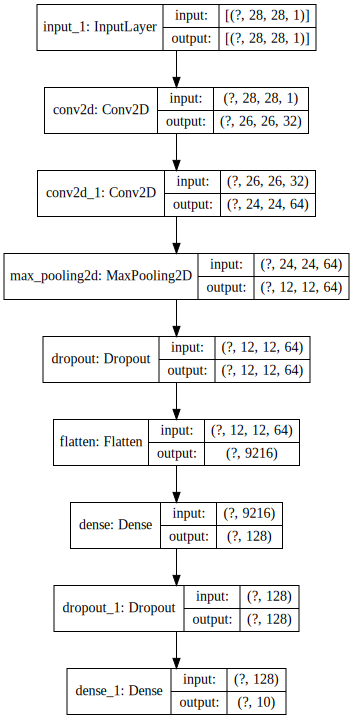

In [19]:
model_to_dot(model, show_shapes=True).write_pdf("img/ood_architecture-nn.pdf")
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

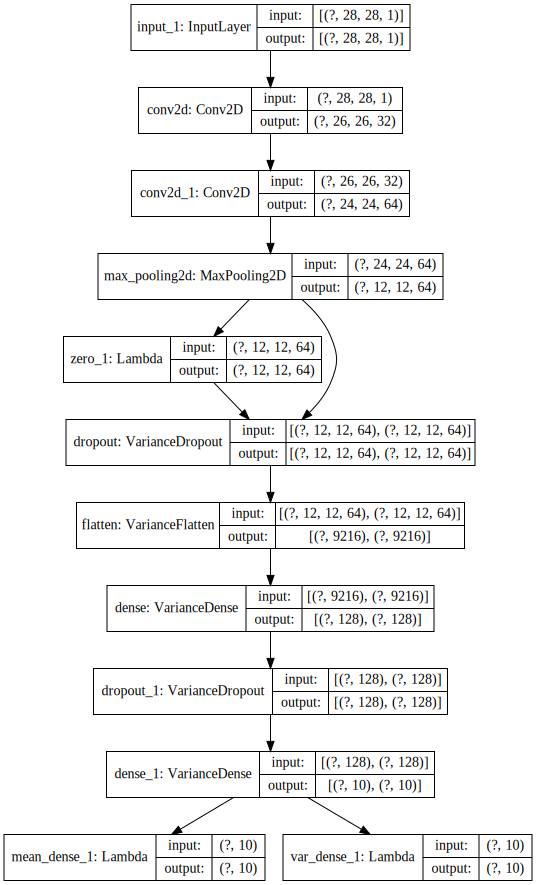

In [20]:
vmodel = nn2vpbnn(model)
model_to_dot(vmodel, show_shapes=True).write_pdf("img/ood_architecture-vpbnn.pdf")
SVG(model_to_dot(vmodel, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [21]:
def calc_auc(df, train_domain, test_domain):
    auc_dfs = []
    for pred_type in df['prediction_type'].unique():
        for bayes_model in df['bayes_model'].unique():
            for activation in df['last_activation'].unique():            
                cond_df = df[df['prediction_type'] == pred_type]
                cond_df = cond_df[cond_df['bayes_model'] == bayes_model]
                cond_df = cond_df[cond_df['last_activation'] == activation]
                fpr, tpr, thresholds = metrics.roc_curve(cond_df['test_domain'], -cond_df['y_uncertainty'], pos_label=train_domain)
                roc_auc = metrics.auc(fpr, tpr)
                auc_df = pd.DataFrame({'train_domain': [train_domain], 'test_domain': [test_domain], 'prediction_type': [pred_type], 'bayes_model': [bayes_model], 'last_activation': [activation], 'auc': [roc_auc]})
                auc_dfs.append(auc_df)
        
    auc_df = pd.concat(auc_dfs, ignore_index=True)
    auc_df['seed'] = df['seed'].iloc[0]
        
    return auc_df

In [22]:
auc_dfs = []
for csv_filepath in sorted(glob.glob('score/*.csv')):
    score_df = pd.read_csv(csv_filepath)
    for train_domain in score_df['train_domain'].unique():
        other_domains = set(score_df['test_domain'].unique()) - set([train_domain])
        for other_domain in other_domains:
            cond = np.logical_and(score_df['train_domain'] == train_domain, np.logical_or(score_df['test_domain'] == train_domain, score_df['test_domain'] == other_domain))
            auc_df = calc_auc(score_df[cond], train_domain, other_domain)
            auc_dfs.append(auc_df)
    auc_df = pd.concat(auc_dfs, ignore_index=True)

In [23]:
pd.set_option("display.max_rows", None)

auc_mean_df = auc_df.groupby(['train_domain', 'test_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'auc': ['mean', 'std']})
auc_mean_df['auc_str'] = auc_mean_df.apply(lambda x: '{0:.3f}±{1:.3f}'.format(x['auc']['mean'], x['auc']['std']), axis=1)
auc_mean_df

auc  \
                                                                                     mean   
train_domain test_domain  prediction_type           bayes_model last_activation             
Fashion      EMNIST-MNIST Independent-mode_entropy  MNIST-CNN   sigmoid          0.855332   
                                                                softmax          0.896740   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.946341   
                                                                softmax          0.921653   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.756029   
                                                                softmax          0.786531   
                          Linear-mode_mean-std      MNIST-CNN   sigmoid          0.834774   
                                                                softmax          0.772979   
                          MC-mode_entropy           MNIST-CNN   sigmoid          0.845637   
                                                                softmax          0.890678   
                          MC-mode_mean-std          MNIST-CNN   sigmoid          0.937224   
                                                                softmax          0.939019   
                          Normal-mode_entropy       MNIST-CNN   sigmoid          0.756029   
                                                                softmax          0.786531   
                          Upper-mode_entropy        MNIST-CNN   sigmoid          0.874432   
                                                                softmax          0.962027   
                          Upper-mode_mean-std       MNIST-CNN   sigmoid          0.943384   
                                                                softmax          0.964623   
             Kannada      Independent-mode_entropy  MNIST-CNN   sigmoid          0.793108   
                                                                softmax          0.868185   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.915267   
                                                                softmax          0.902193   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.670356   
                                                                softmax          0.720845   
                          Linear-mode_mean-std      MNIST-CNN   sigmoid          0.764418   
                                                                softmax          0.732392   
                          MC-mode_entropy           MNIST-CNN   sigmoid          0.782360   
                                                                softmax          0.864453   
                          MC-mode_mean-std          MNIST-CNN   sigmoid          0.907438   
                                                                softmax          0.928981   
                          Normal-mode_entropy       MNIST-CNN   sigmoid          0.670356   
                                                                softmax          0.720845   
                          Upper-mode_entropy        MNIST-CNN   sigmoid          0.814782   
                                                                softmax          0.953602   
                          Upper-mode_mean-std       MNIST-CNN   sigmoid          0.917455   
                                                                softmax          0.958967   
             Kuzushiji    Independent-mode_entropy  MNIST-CNN   sigmoid          0.892196   
                                                                softmax          0.925693   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.981290   
                                                                softmax          0.951199   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.7669

In [24]:
accuracy_dfs = []
for csv_filepath in sorted(glob.glob('score/*.csv')):
    df = pd.read_csv(csv_filepath)
    df = df[df['train_domain'] == df['test_domain']]
    df['correct'] = df['y_test'] == df['y_pred']
    accuracy_df = df[['train_domain', 'prediction_type', 'bayes_model', 'last_activation', 'correct']].groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).mean().reset_index()
    accuracy_df = accuracy_df.rename(columns={'correct': 'accuracy'})
    accuracy_df['seed'] = df['seed'].iloc[0]
    accuracy_dfs.append(accuracy_df)
accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)

In [25]:
accuracy_mean_df = accuracy_df.groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'accuracy': ['mean', 'std']})
accuracy_mean_df['accuracy_str'] = accuracy_mean_df.apply(lambda x: '{0:.3f}±{1:.3f}'.format(x['accuracy']['mean'], x['accuracy']['std']), axis=1)
accuracy_mean_df

accuracy  \
                                                                        mean   
train_domain prediction_type           bayes_model last_activation             
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.922750   
                                                   softmax          0.923413   
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.922750   
                                                   softmax          0.923413   
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.922787   
                                                   softmax          0.923363   
             Linear-mode_mean-std      MNIST-CNN   sigmoid          0.922787   
                                                   softmax          0.923363   
             MC-mode_entropy           MNIST-CNN   sigmoid          0.922770   
                                                   softmax          0.923503   
             MC-mode_mean-std          MNIST-CNN   sigmoid          0.922770   
                                                   softmax          0.923503   
             Normal-mode_entropy       MNIST-CNN   sigmoid          0.922787   
                                                   softmax          0.923363   
             Upper-mode_entropy        MNIST-CNN   sigmoid          0.921763   
                                                   softmax          0.922180   
             Upper-mode_mean-std       MNIST-CNN   sigmoid          0.921763   
                                                   softmax          0.922180   

                                                                              \
                                                                         std   
train_domain prediction_type           bayes_model last_activation             
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.002503   
                                                   softmax          0.002323   
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.002503   
                                                   softmax          0.002323   
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.002550   
                                                   softmax          0.002235   
             Linear-mode_mean-std      MNIST-CNN   sigmoid          0.002550   
                                                   softmax          0.002235   
             MC-mode_entropy           MNIST-CNN   sigmoid          0.002438   
                                                   softmax          0.002345   
             MC-mode_mean-std          MNIST-CNN   sigmoid          0.002438   
                                                   softmax          0.002345   
             Normal-mode_entropy       MNIST-CNN   sigmoid          0.002550   
                                                   softmax          0.002235   
             Upper-mode_entropy        MNIST-CNN   sigmoid          0.002399   
                                                   softmax          0.002437   
             Upper-mode_mean-std       MNIST-CNN   sigmoid          0.002399   
                                                   softmax          0.002437   

                                                                   accuracy_str  
                                                                                 
train_domain prediction_type           bayes_model last_activation               
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.923±0.003  
                                                   softmax          0.923±0.002  
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.923±0.003  
                                                   softmax          0.923±0.002  
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.923±0.003  
                                                  